In [272]:
import torch 
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np 
import matplotlib.pyplot as plt

In [273]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [274]:
g = torch.Generator().manual_seed(SEED)

In [275]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [276]:
root = r"C:\Users\yacan\Desktop\Pytorch\dataset"
DATASET_NAME = "CIFAR10"

In [277]:
base_train = datasets.CIFAR10(root=root, train=True, download=True, transform=None)
base_test = datasets.CIFAR10(root=root, train=False, download=True, transform=None)
classes = base_train.classes

### Dataset 

In [278]:
from PIL import Image

In [279]:
class CIFARDataset(Dataset):
    def __init__(self, ds, indices=None, transforms=None):
        self.data = ds.data
        self.targets = ds.targets
        self.indices = list(range(len(self.data))) if indices is None else list(indices)
        self.transforms = transforms

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img, target = self.data[self.indices[idx]], self.targets[self.indices[idx]]

        img = Image.fromarray(img)
        if self.transforms:
            img = self.transforms(img)
        return img, target


In [280]:
validation_ratio = 0.1
N = len(base_train)
validation_size = int(N * validation_ratio)

perm = torch.randperm(N, generator=g)
train_indices = perm[validation_size:].tolist()
val_indices = perm[:validation_size].tolist()

In [281]:
mean, std = (0.4917, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [282]:
train_ds = CIFARDataset(base_train, indices=train_indices, transforms=train_transforms)
val_ds = CIFARDataset(base_train, indices=val_indices, transforms=val_transforms)
test_ds = CIFARDataset(base_test, transforms=val_transforms)


In [283]:
print("Train Size:", len(train_ds))
print("Validation Size:", len(val_ds))
print("Test Size:", len(test_ds))

Train Size: 45000
Validation Size: 5000
Test Size: 10000


### DataLoader

In [284]:
BATCH_SIZE = 128
pin_memory = torch.cuda.is_available()

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=pin_memory, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, pin_memory=pin_memory, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, pin_memory=pin_memory, num_workers=0)

print("Train Loader Size:", len(train_loader))
print("Validation Loader Size:", len(val_loader))
print("Test Loader Size:", len(test_loader))

Train Loader Size: 352
Validation Loader Size: 40
Test Loader Size: 79


In [285]:
x, y = next(iter(train_loader))
print("Batch X shape:", x.shape)
print("Batch X dtype:", x.dtype)
print("Batch Y shape:", y.shape)
print("Batch Y dtype:", y.dtype)

Batch X shape: torch.Size([128, 3, 32, 32])
Batch X dtype: torch.float32
Batch Y shape: torch.Size([128])
Batch Y dtype: torch.int64


In [286]:
mean_t = torch.tensor(mean).view(len(mean),1 ,1)
std_t = torch.tensor(std).view(len(std),1 ,1)

def unnormalize(x_image):
    return x_image * std_t + mean_t



In [287]:
grid = torchvision.utils.make_grid(unnormalize(x[:32]))

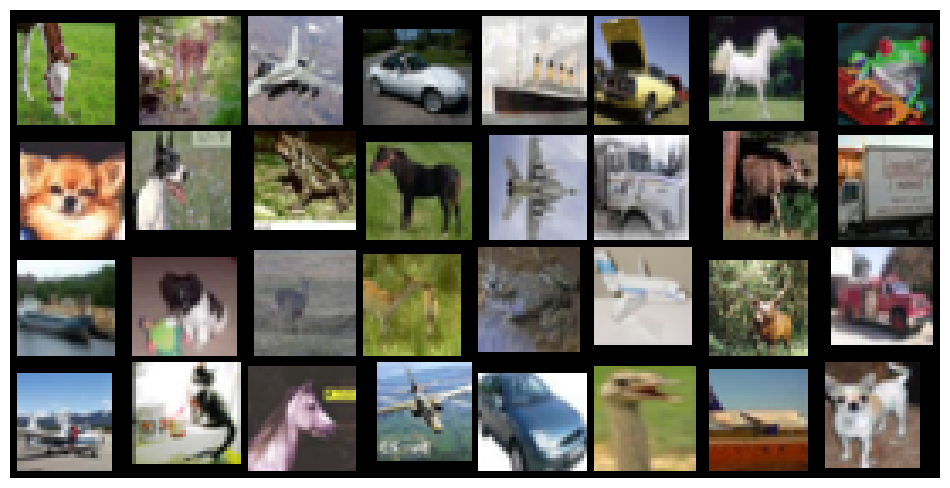

In [288]:
plt.figure(figsize=(12, 12))
if grid.shape[0] == 1:
    plt.imshow(grid.squeeze(0), cmap="gray")
else: 
    plt.imshow(grid.permute(1, 2, 0).clamp(0, 1))
plt.axis("off")
plt.show()

In [289]:
print("İlk 10 görüntünün sınıfları:", [classes[int(y)] for y in y[:32]])

İlk 10 görüntünün sınıfları: ['horse', 'deer', 'airplane', 'automobile', 'ship', 'automobile', 'horse', 'frog', 'dog', 'dog', 'frog', 'horse', 'airplane', 'truck', 'deer', 'truck', 'ship', 'dog', 'deer', 'deer', 'frog', 'airplane', 'deer', 'truck', 'airplane', 'cat', 'horse', 'airplane', 'automobile', 'bird', 'airplane', 'dog']


### Model Training

In [291]:
from SmallModel import SmallCifarNet

model = SmallCifarNet(num_classes=len(classes)).to(device)
 # cuda
model 

SmallCifarNet(
  (Block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
  )
  (Block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inpl

In [292]:
import torch.nn as nn 
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [293]:
def train(model, dataloader, criterion, optimizer, device):

    model.train()
    total_loss, correct, total = 0, 0, 0

    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad() # gradyanları sıfırladık
        logits = model(xb) # görüntüleri modele verdik
        loss = criterion(logits, yb)

        loss.backward() # gradyan hesaplama yapılır geriye yayılım * autograd
        optimizer.step() # apırlık ve bias güncellenmesi yapılır

        total_loss += loss.item() *yb.size(0)
        correct += (logits.argmax(1) == yb).sum().item()
        total += yb.size(0)
    
    avg_loss = total_loss / total
    acc = correct / total

    return avg_loss, acc 




In [294]:
@torch.no_grad()
def evaluate(model, dataloader, criterion, device):

    model.eval()
    total_loss, correct, total = 0, 0, 0

    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb)
        loss = criterion(logits, yb)

        total_loss += loss.item() *yb.size(0)
        correct += (logits.argmax(1) == yb).sum().item()
        total += yb.size(0)
    
    avg_loss = total_loss / total
    acc = correct / total

    return avg_loss, acc

In [295]:
epochs = 30
file_path = "small_cifar_net.pt"

for epoch in range(1, epochs + 1):

    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)

    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch:02d}: Train Loss {train_loss*100:.2f}, Train Acc {train_acc*100:.2f}, Val Loss {val_loss*100:.2f}, Val Acc {val_acc*100:.2f}")

    torch.save({
        "model_state": model.state_dict(),
        "epoch": epoch,
        "mean": mean,
        "std": std,
        "classes": classes,
        "arch" : "SmallCifarNet"
    }, file_path)




Epoch 01: Train Loss 180.16, Train Acc 32.87, Val Loss 150.01, Val Acc 46.66
Epoch 02: Train Loss 128.41, Train Acc 53.34, Val Loss 119.38, Val Acc 57.00
Epoch 03: Train Loss 107.58, Train Acc 61.77, Val Loss 101.53, Val Acc 64.42
Epoch 04: Train Loss 95.53, Train Acc 66.52, Val Loss 76.73, Val Acc 72.24
Epoch 05: Train Loss 86.67, Train Acc 70.03, Val Loss 78.92, Val Acc 73.08
Epoch 06: Train Loss 79.43, Train Acc 72.46, Val Loss 69.58, Val Acc 76.00
Epoch 07: Train Loss 73.62, Train Acc 74.74, Val Loss 70.73, Val Acc 75.64
Epoch 08: Train Loss 69.67, Train Acc 76.20, Val Loss 61.12, Val Acc 79.28
Epoch 09: Train Loss 65.30, Train Acc 77.65, Val Loss 55.37, Val Acc 81.28
Epoch 10: Train Loss 62.10, Train Acc 79.01, Val Loss 50.54, Val Acc 82.44
Epoch 11: Train Loss 58.94, Train Acc 80.05, Val Loss 54.69, Val Acc 81.76
Epoch 12: Train Loss 56.64, Train Acc 80.62, Val Loss 47.95, Val Acc 83.62
Epoch 13: Train Loss 54.18, Train Acc 81.77, Val Loss 48.32, Val Acc 84.00
Epoch 14: Train Los